In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from keras.optimizers import AdamW 
from sklearn.metrics import (
    accuracy_score, classification_report, precision_recall_fscore_support,
    cohen_kappa_score, matthews_corrcoef, roc_auc_score, confusion_matrix, 
    precision_recall_curve, average_precision_score, roc_curve, auc
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.applications import MobileNetV2 # type: ignore
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout # type: ignore

In [2]:
dataset_path = "E:\Homework\College\Semester 6\PI\Program\dataset\garbage-dataset"
IMG_SIZE = 224
BATCH_SIZE = 32
CLASS_NAMES = ['cardboard','clothes', 'glass', 'metal', 'paper', 'plastic','shoes', 'tidak diketahui']

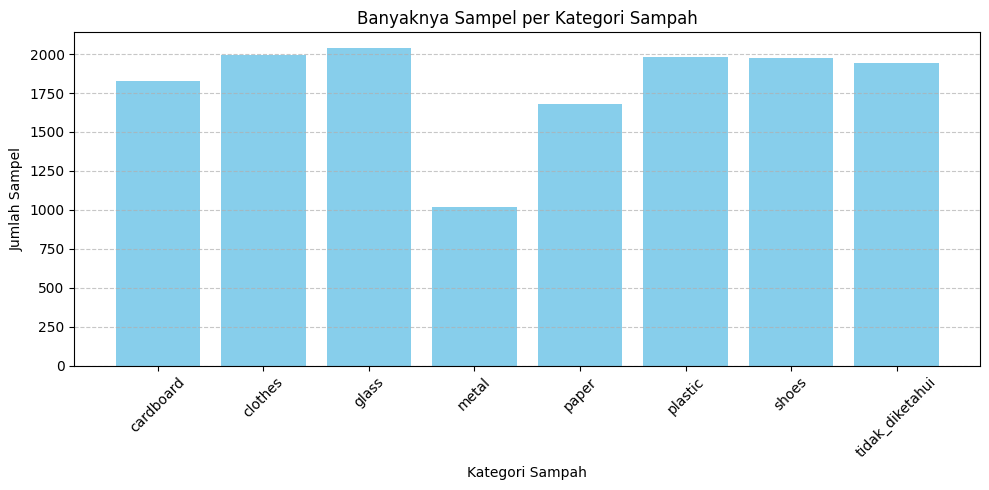

In [3]:
data_path = "dataset/garbage-dataset"

class_counts = {
    category: len(os.listdir(os.path.join(data_path, category)))
    for category in os.listdir(data_path)
    if os.path.isdir(os.path.join(data_path, category))  
}

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Banyaknya Sampel per Kategori Sampah")
plt.xlabel("Kategori Sampah")
plt.ylabel("Jumlah Sampel")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [4]:

# Path dataset
dataset_dir = "dataset\garbage-dataset"

# Membuat dataframe dari file dataset
data = []
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            if os.path.isfile(file_path):
                size = os.path.getsize(file_path)  # ukuran file (bytes)
                data.append([class_name, file, file_path, size])

df = pd.DataFrame(data, columns=["class", "filename", "filepath", "filesize"])


print("Jumlah data kosong per kolom:")
print(df.isna().sum())


print("\nJumlah file corrupt (size 0):", (df["filesize"] == 0).sum())


print("\nJumlah duplikat nama file:", df["filename"].duplicated().sum())

Jumlah data kosong per kolom:
class       0
filename    0
filepath    0
filesize    0
dtype: int64

Jumlah file corrupt (size 0): 0

Jumlah duplikat nama file: 0


In [5]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 11574 images belonging to 8 classes.
Found 2890 images belonging to 8 classes.


In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

In [7]:
# Membuat base model dengan MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Tahap awal: freeze semua layer
base_model.trainable = False 

# Tambahkan lapisan fully connected di atas base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Optimizer
optimizer = AdamW(learning_rate=1e-4)  

# Compile model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Hitung class weight untuk menangani imbalance
labels = train_data.classes  

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Konversi ke dictionary
class_weights_dict = dict(enumerate(class_weights))

# Training awal (feature extractor stage)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)


e:\Homework\College\Semester 6\PI\Program\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
362/362 ━━━━━━━━━━━━━━━━━━━━ 793s 2s/step - accuracy: 0.2813 - loss: 2.0407 - val_accuracy: 0.7304 - val_loss: 0.9206 - learning_rate: 1.0000e-04
Epoch 2/25
362/362 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - accuracy: 0.6865 - loss: 0.9850 - val_accuracy: 0.8145 - val_loss: 0.6314 - learning_rate: 1.0000e-04
Epoch 3/25
362/362 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.7716 - loss: 0.7259 - val_accuracy: 0.8478 - val_loss: 0.5124 - learning_rate: 1.0000e-04
Epoch 4/25
362/362 ━━━━━━━━━━━━━━━━━━━━ 519s 1s/step - accuracy: 0.8130 - loss: 0.5925 - val_accuracy: 0.8654 - val_loss: 0.4540 - learning_rate: 1.0000e-04
Epoch 5/25
362/362 ━━━━━━━━━━━━━━━━━━━━ 306s 845ms/step - accuracy: 0.8339 - loss: 0.5350 - val_accuracy: 0.8761 - val_loss: 0.4014 - learning_rate: 1.0000e-04
Epoch 6/25
362/362 ━━━━━━━━━━━━━━━━━━━━ 236s 652ms/step - accuracy: 0.8435 - loss: 0.4973 - val_accuracy: 0.8761 - val_loss: 0.3920 - learning_rate: 1.0000e-04
Epoch 7/25
362/362 ━━━━━━━━━━━━━━━━━━━━ 238s 657ms/s

In [10]:
# Fine-tuning tahap 2: buka sebagian layer terakhir
base_model.trainable = True
for layer in base_model.layers[:-30]:  # bekukan semua kecuali 30 layer terakhir
    layer.trainable = False

# Compile ulang dengan learning rate lebih kecil
model.compile(
    optimizer=AdamW(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Lanjutkan training fine-tuning
history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)


Epoch 1/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.8655 - loss: 0.4031 - val_accuracy: 0.9145 - val_loss: 0.2626 - learning_rate: 1.0000e-05
Epoch 2/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 348s 960ms/step - accuracy: 0.8932 - loss: 0.3190 - val_accuracy: 0.9170 - val_loss: 0.2638 - learning_rate: 1.0000e-05
Epoch 3/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 258s 713ms/step - accuracy: 0.9006 - loss: 0.2933 - val_accuracy: 0.9125 - val_loss: 0.2559 - learning_rate: 1.0000e-05
Epoch 4/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 265s 732ms/step - accuracy: 0.9111 - loss: 0.2734 - val_accuracy: 0.9156 - val_loss: 0.2540 - learning_rate: 1.0000e-05
Epoch 5/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 260s 719ms/step - accuracy: 0.9153 - loss: 0.2519 - val_accuracy: 0.9221 - val_loss: 0.2454 - learning_rate: 1.0000e-05
Epoch 6/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.9242 - loss: 0.2267 - val_accuracy: 0.9232 - val_loss: 0.2366 - learning_rate: 1.0000e-05
Epoch 7/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 265s 7

In [11]:
loss, acc = model.evaluate(train_data)
print(f"Training Accuracy: {acc * 100:.2f}%")
print(f"Training Loss: {loss:.4f}")

362/362 ━━━━━━━━━━━━━━━━━━━━ 219s 605ms/step - accuracy: 0.9680 - loss: 0.0969
Training Accuracy: 96.78%
Training Loss: 0.1000


In [12]:
loss, acc = model.evaluate(val_data)
print(f"Validation Accuracy: {acc * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

91/91 ━━━━━━━━━━━━━━━━━━━━ 56s 615ms/step - accuracy: 0.9370 - loss: 0.2084
Validation Accuracy: 93.81%
Validation Loss: 0.2052


In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# === Evaluasi pada Data Latih ===
train_data.reset()
y_proba_train = model.predict(train_data, verbose=0)
y_pred_train  = np.argmax(y_proba_train, axis=1)
y_true_train  = train_data.classes

index_to_class = {v: k for k, v in train_data.class_indices.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

print("=== Evaluasi Data Latih ===")
acc_train = accuracy_score(y_true_train, y_pred_train)
print(f"Akurasi (Top-1) Train: {acc_train*100:.2f}%")

p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_train, y_pred_train, average="macro", zero_division=0
)
print(f"Macro Precision/Recall/F1 (Train): {p_macro:.3f} / {r_macro:.3f} / {f1_macro:.3f}")

print("\n=== Classification Report (per kelas, Train) ===")
print(classification_report(y_true_train, y_pred_train, target_names=target_names, zero_division=0))

print(f"Cohen's Kappa (Train): {cohen_kappa_score(y_true_train, y_pred_train):.3f}")
print(f"Matthews Corrcoef (MCC, Train): {matthews_corrcoef(y_true_train, y_pred_train):.3f}")

# ROC-AUC multikelas
y_true_bin_train = label_binarize(y_true_train, classes=list(range(len(target_names))))
auc_macro_train = roc_auc_score(y_true_bin_train, y_proba_train, average="macro", multi_class="ovr")
auc_weighted_train = roc_auc_score(y_true_bin_train, y_proba_train, average="weighted", multi_class="ovr")
print(f"ROC–AUC macro (Train): {auc_macro_train:.3f}")
print(f"ROC–AUC weighted (Train): {auc_weighted_train:.3f}")

=== Evaluasi Data Latih ===
Akurasi (Top-1) Train: 12.56%
Macro Precision/Recall/F1 (Train): 0.122 / 0.122 / 0.122

=== Classification Report (per kelas, Train) ===
                 precision    recall  f1-score   support

      cardboard       0.13      0.13      0.13      1460
        clothes       0.13      0.13      0.13      1597
          glass       0.13      0.13      0.13      1631
          metal       0.07      0.07      0.07       816
          paper       0.12      0.12      0.12      1344
        plastic       0.13      0.13      0.13      1588
          shoes       0.13      0.13      0.13      1582
tidak_diketahui       0.14      0.14      0.14      1556

       accuracy                           0.13     11574
      macro avg       0.12      0.12      0.12     11574
   weighted avg       0.13      0.13      0.13     11574

Cohen's Kappa (Train): -0.003
Matthews Corrcoef (MCC, Train): -0.003
ROC–AUC macro (Train): 0.499
ROC–AUC weighted (Train): 0.499


In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# === Evaluasi pada Data Latih ===
train_data.reset()
y_proba_train = model.predict(train_data, verbose=0)
y_pred_train  = np.argmax(y_proba_train, axis=1)
y_true_train  = train_data.classes

index_to_class = {v: k for k, v in train_data.class_indices.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

print("=== Evaluasi Data Latih ===")
acc_train = accuracy_score(y_true_train, y_pred_train)
print(f"Akurasi (Top-1) Train: {acc_train*100:.2f}%")

p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_train, y_pred_train, average="macro", zero_division=0
)
print(f"Macro Precision/Recall/F1 (Train): {p_macro:.3f} / {r_macro:.3f} / {f1_macro:.3f}")

print("\n=== Classification Report (per kelas, Train) ===")
print(classification_report(y_true_train, y_pred_train, target_names=target_names, zero_division=0))

print(f"Cohen's Kappa (Train): {cohen_kappa_score(y_true_train, y_pred_train):.3f}")
print(f"Matthews Corrcoef (MCC, Train): {matthews_corrcoef(y_true_train, y_pred_train):.3f}")

# ROC-AUC multikelas
y_true_bin_train = label_binarize(y_true_train, classes=list(range(len(target_names))))
auc_macro_train = roc_auc_score(y_true_bin_train, y_proba_train, average="macro", multi_class="ovr")
auc_weighted_train = roc_auc_score(y_true_bin_train, y_proba_train, average="weighted", multi_class="ovr")
print(f"ROC–AUC macro (Train): {auc_macro_train:.3f}")
print(f"ROC–AUC weighted (Train): {auc_weighted_train:.3f}")

# === Evaluasi pada Data Validasi ===
val_data.reset()
y_proba_val = model.predict(val_data, verbose=0)
y_pred_val  = np.argmax(y_proba_val, axis=1)
y_true_val  = val_data.classes

print("\n=== Evaluasi Data Validasi ===")
acc_val = accuracy_score(y_true_val, y_pred_val)
print(f"Akurasi (Top-1) Validasi: {acc_val*100:.2f}%")

p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_val, y_pred_val, average="macro", zero_division=0
)
print(f"Macro Precision/Recall/F1 (Val): {p_macro:.3f} / {r_macro:.3f} / {f1_macro:.3f}")

print("\n=== Classification Report (per kelas, Val) ===")
print(classification_report(y_true_val, y_pred_val, target_names=target_names, zero_division=0))

print(f"Cohen's Kappa (Val): {cohen_kappa_score(y_true_val, y_pred_val):.3f}")
print(f"Matthews Corrcoef (MCC, Val): {matthews_corrcoef(y_true_val, y_pred_val):.3f}")

# ROC-AUC multikelas
y_true_bin_val = label_binarize(y_true_val, classes=list(range(len(target_names))))
auc_macro_val = roc_auc_score(y_true_bin_val, y_proba_val, average="macro", multi_class="ovr")
auc_weighted_val = roc_auc_score(y_true_bin_val, y_proba_val, average="weighted", multi_class="ovr")
print(f"ROC–AUC macro (Val): {auc_macro_val:.3f}")
print(f"ROC–AUC weighted (Val): {auc_weighted_val:.3f}")


=== Evaluasi Data Latih ===
Akurasi (Top-1) Train: 12.99%
Macro Precision/Recall/F1 (Train): 0.126 / 0.126 / 0.126

=== Classification Report (per kelas, Train) ===
                 precision    recall  f1-score   support

      cardboard       0.13      0.13      0.13      1460
        clothes       0.12      0.12      0.12      1597
          glass       0.14      0.14      0.14      1631
          metal       0.06      0.06      0.06       816
          paper       0.12      0.12      0.12      1344
        plastic       0.14      0.13      0.14      1588
          shoes       0.14      0.15      0.15      1582
tidak_diketahui       0.15      0.15      0.15      1556

       accuracy                           0.13     11574
      macro avg       0.13      0.13      0.13     11574
   weighted avg       0.13      0.13      0.13     11574

Cohen's Kappa (Train): 0.001
Matthews Corrcoef (MCC, Train): 0.001
ROC–AUC macro (Train): 0.502
ROC–AUC weighted (Train): 0.502

=== Evaluasi Data V

In [1]:
plt.figure(figsize=(8,6))
for i, name in enumerate(target_names):
    # Lewati kelas yang tidak muncul di validasi
    if y_true_bin[:, i].sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.tight_layout()
plt.savefig("roc_multiclass.png", dpi=300)
plt.show()

NameError: name 'plt' is not defined

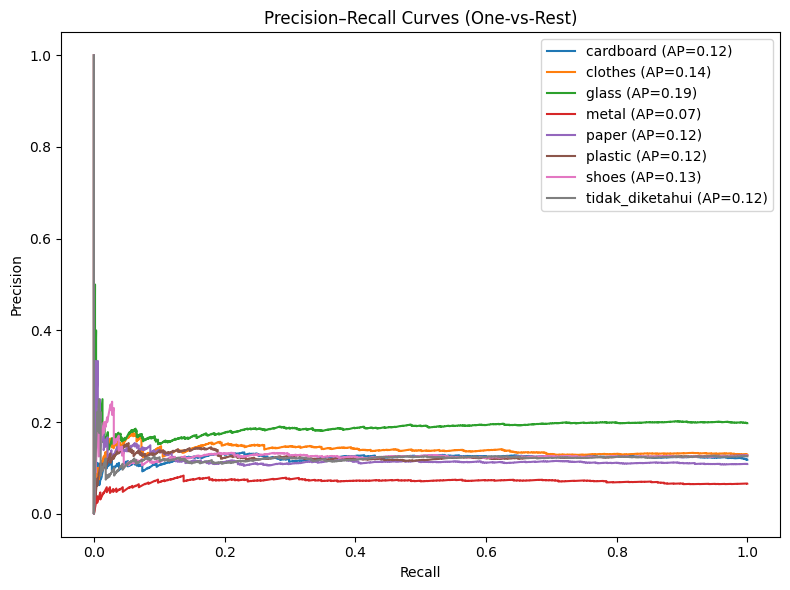

In [20]:
plt.figure(figsize=(8,6))
for i, name in enumerate(target_names):
    if y_true_bin[:, i].sum() == 0:
        continue
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (One-vs-Rest)")
plt.legend()
plt.tight_layout()
plt.savefig("pr_multiclass.png", dpi=300)
plt.show()

91/91 ━━━━━━━━━━━━━━━━━━━━ 57s 626ms/step


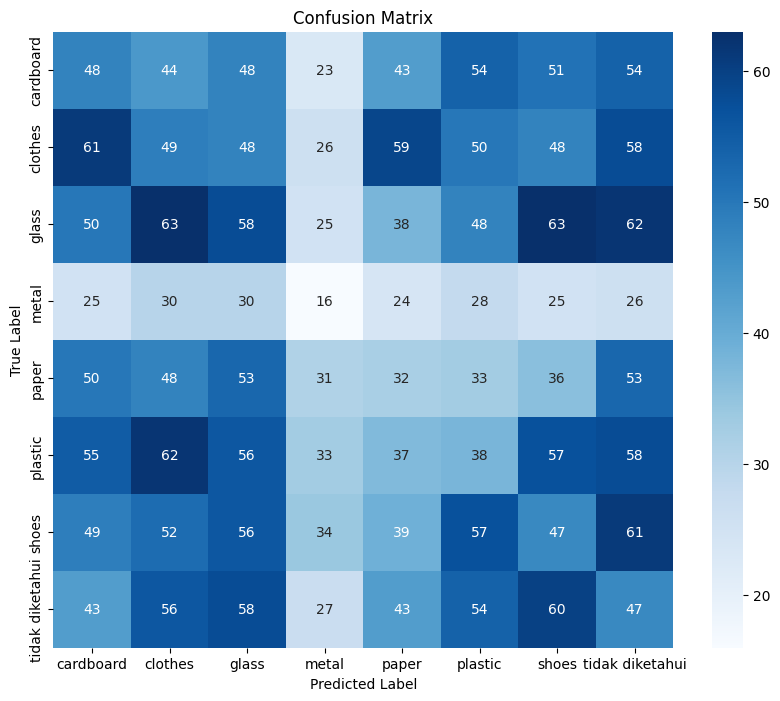

In [18]:
Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


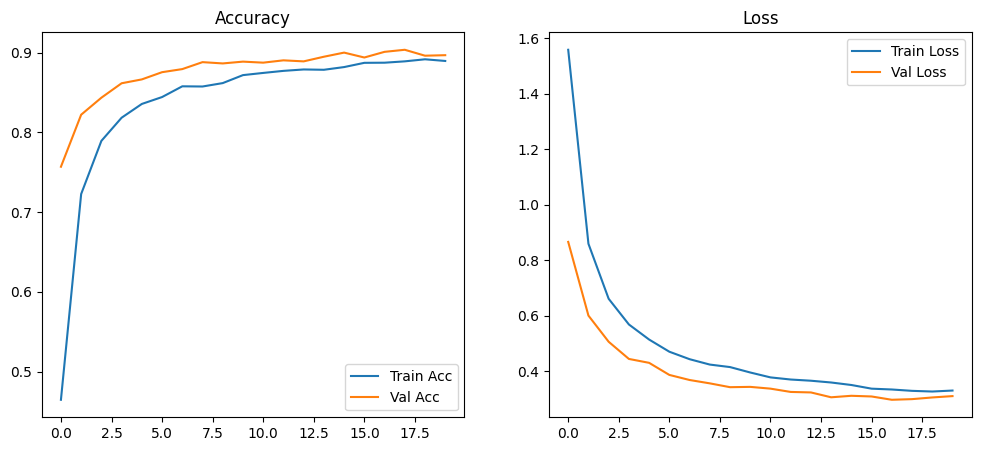

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [19]:
model.save("trash_classifier1.5.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


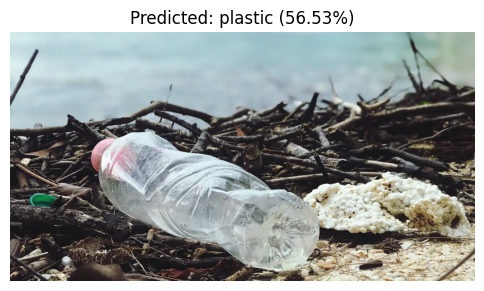

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


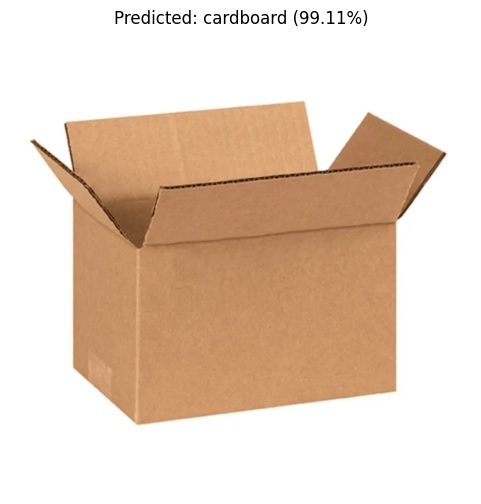

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


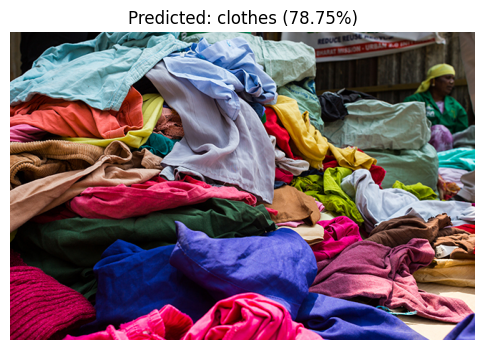

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


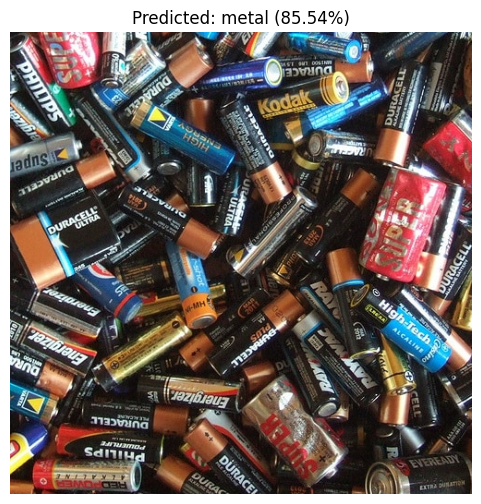

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


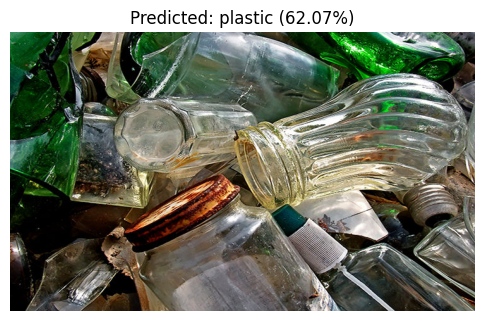

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


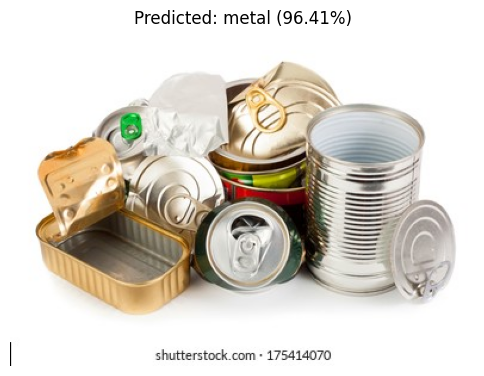

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


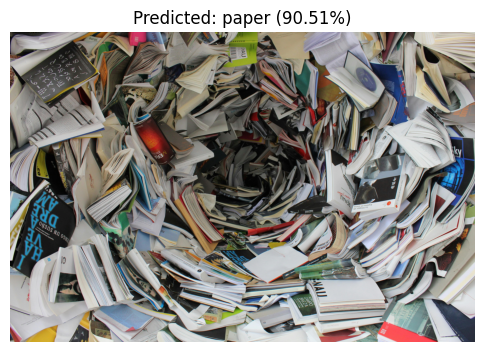

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


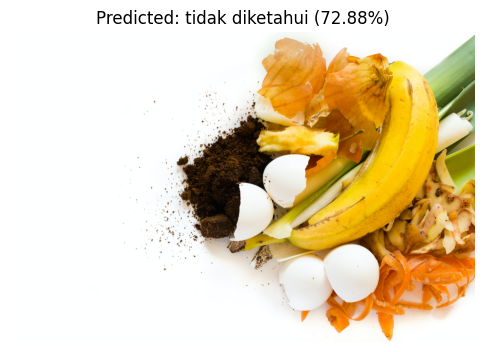

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


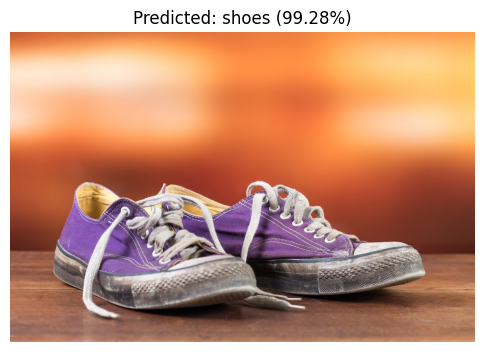

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


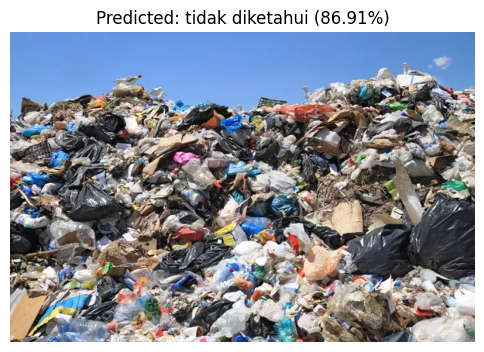

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


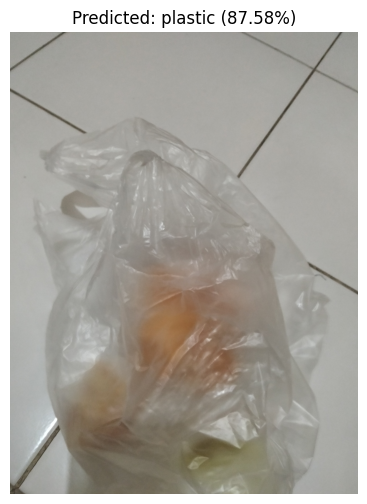

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


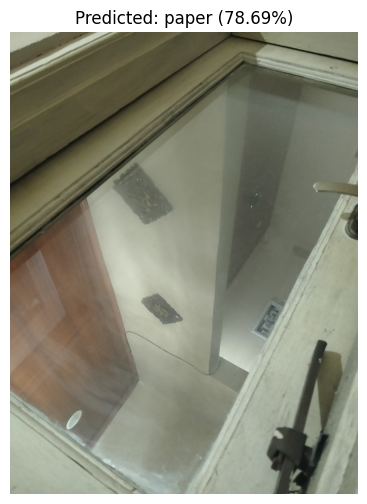

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


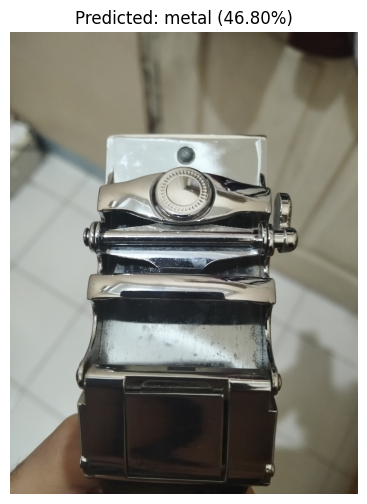

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


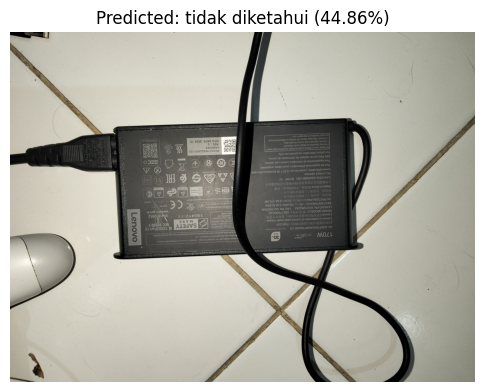

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


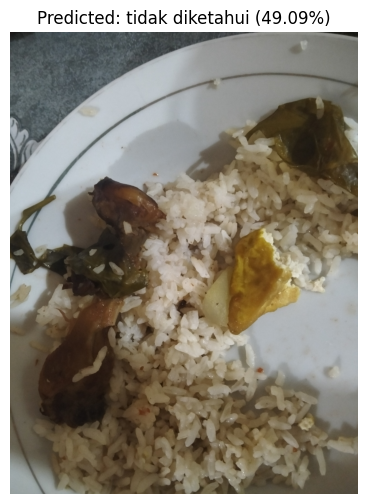

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


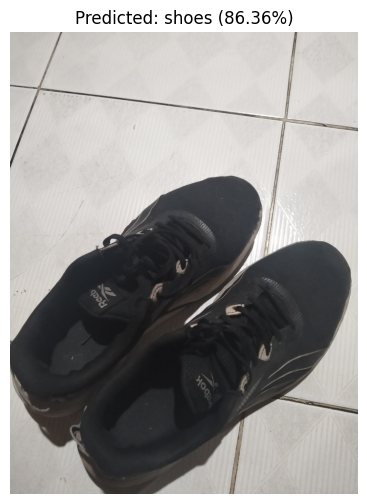

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


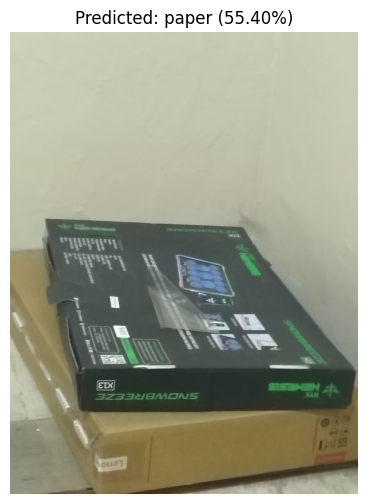

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


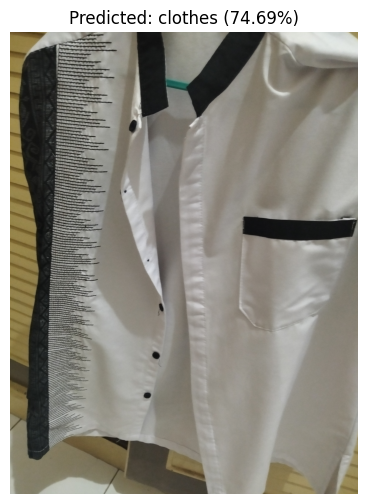

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


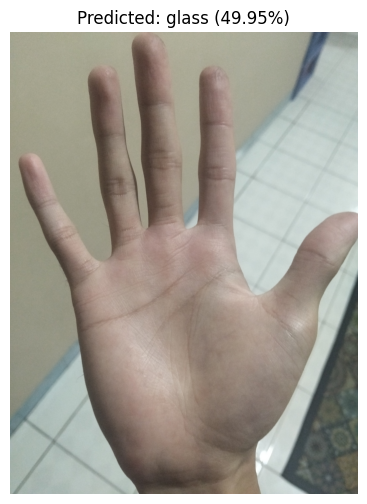

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


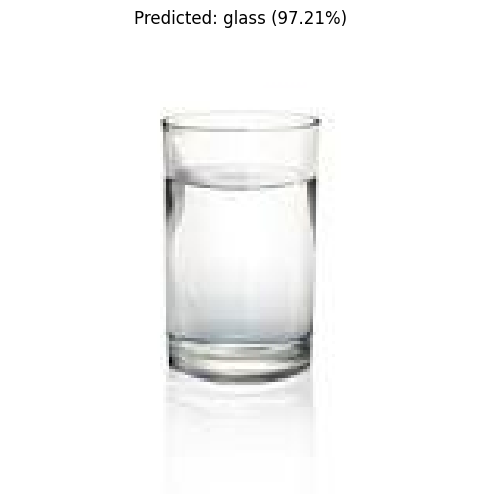

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model #type:ignore
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input #type:ignore
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import os

# Define class names
CLASS_NAMES = ['cardboard', 'clothes', 'glass',
               'metal', 'paper', 'plastic', 'shoes', 'tidak diketahui']

# Load model
model_path = r'E:\Homework\College\Semester 6\PI\Program\trash_classifier_web\model\trash_classifier1.4.h5'
model = load_model(model_path)

# List of image sources (URLs and local paths)
image_sources = [
    "https://www.officeh2o.com/wp-content/uploads/2020/02/why-are-disposable-water-bottles-harmful-to-the-environment.webp",
    "https://itppackaging.com/wp-content/uploads/2021/02/box.jpg",
    "https://www.intellecap.com/wp-content/uploads/2024/05/new_case_study02.jpg",
    "https://sustainingourworld.com/wp-content/uploads/2014/09/Dead-batteries.jpg",
    "https://tipitrubbishremoval.com.au/wp-content/uploads/2022/06/glass-recycling-why-you-shouldnt-throw-glass-rubbish-in-the-bin-1.jpeg",
    "https://www.shutterstock.com/image-photo/empty-metal-cans-waiting-on-260nw-175414070.jpg",
    "https://cdn.prod.website-files.com/6076eb6f757c580e3cd74f70/65e73f3864826dcd7ada8953_pexels-pixabay-159751.jpg",
    "https://www.nycfoodpolicy.org/wp-content/uploads/2020/02/shutterstock_619780853.png",
    "https://wastemanagementreview.com.au/wp-content/uploads/2022/08/old-shoes.jpeg",
    "https://st.depositphotos.com/1005914/2556/i/450/depositphotos_25567715-stock-photo-garbage-and-seagulls.jpg",
    r"trash_classifier_web\static\Test1.jpg",
    r"trash_classifier_web\static\Test2.jpg",
    r"trash_classifier_web\static\Test3.jpg",
    r"trash_classifier_web\static\Test4.jpg",
    r"trash_classifier_web\static\Test5.jpg",
    r"trash_classifier_web\static\Test6.jpg",
    r"trash_classifier_web\static\Test7.jpg",
    r"trash_classifier_web\static\Test8.jpg",
    r"trash_classifier_web\static\Test9.jpg",
    r"trash_classifier_web\static\Test11.jpg"
]

# Define target image size
img_size = (224, 224)

# Process and predict each image
for source in image_sources:
    try:
        # Load image
        if source.startswith('http'):
            response = requests.get(source)
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            if not os.path.exists(source):
                raise FileNotFoundError(f"File not found: {source}")
            img = Image.open(source).convert('RGB')

        # Resize and preprocess image (konsisten dengan training)
        resized_img = img.resize(img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(resized_img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array) 

        # Predict
        predictions = model.predict(img_array)
        predicted_class = CLASS_NAMES[np.argmax(predictions)]
        confidence = np.max(predictions)

        # Show result
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print(f"Failed to process {source}: {e}")